In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import generate

# GENERATE SYNTHETIC IMAGE

In [3]:
sample = 35
main_path = '/Users/m_feriansyahrt/Documents/S2/PCL/Proyek/day2night/dataset'
noise_model_path = 'noise_profiler/h-gauss-s20-v1'
night_illum_path = 'utils/gray_card_illum_dict.mat'

# camera pipeline parameters
stages = ['raw', 'active_area_cropping', 'linearization', 'normal', 'white_balance',
          'demosaic', 'xyz', 'srgb', 'fix_orient', 'gamma', 'tone']

params = {
    'save_as': 'png',  # options: 'jpg', 'png', 'tif', etc.
    'white_balancer': 'default',  # options: default, or self-defined module
    'demosaicer': 'menon2007',  # options: '' for simple interpolation,
    #          'EA' for edge-aware,
    #          'VNG' for variable number of gradients,
    #          'menon2007' for Menon's algorithm
    'tone_curve': 'simple-s-curve',  # options: 'simple-s-curve', 'default', or self-defined module
}

iso_list = '50,1600,3200'.split(',')
for i in range(0, len(iso_list)):
    iso_list[i] = int(iso_list[i])

dim = True
relight = True
iso = iso_list[1]
discard_black_level = False
_clip = True
relight_local = True
min_num_lights = 2
max_num_lights = 3
min_light_size = 2
max_light_size = 3
num_sat_lights = 0
noised = True

params_synth = {'dim' : dim, 'relight' : relight, 'iso' : iso,
            'discard_black_level' : discard_black_level,
            '_clip' : _clip, 
            'relight_local' : relight_local,
            'min_num_lights' : min_num_lights, 'max_num_lights' : max_num_lights,
            'min_light_size' : min_light_size, 'max_light_size' : max_light_size,
            'num_sat_lights' : num_sat_lights}

In [4]:
# Generate Synthetic Image

day,clean,clean_raw,metadata_raw,noisy,noisy_raw = generate.generate_synthetic_image(sample,main_path,
                                                noise_model_path,night_illum_path,
                                                stages,params,noisy_im = noised,**params_synth)

In [5]:
# Save semua citra ke path

save_path = '/Users/m_feriansyahrt/Documents/S2/PCL/Proyek/day2night/RAW_DATA/'

generate.save_clean_raw_image(save_path,clean,clean_raw,metadata_raw,noisy,noisy_raw)

In [ ]:
plt.imshow(day)
plt.title('Original Day Image')
plt.axis('off')

(-0.5, 4031.5, 3023.5, -0.5)

(-0.5, 4031.5, 3023.5, -0.5)

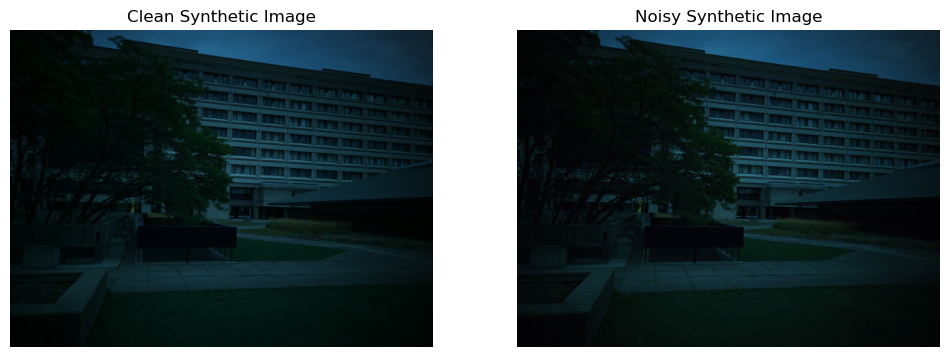

In [ ]:
fig,ax = plt.subplots(1,2,figsize = [12,8])
#ax[0].imshow(rgb)
ax[0].imshow(clean)
ax[0].set_title('Clean Synthetic Image')
ax[0].axis('off')
ax[1].imshow(noisy)
ax[1].set_title('Noisy Synthetic Image')
ax[1].axis('off')

# SECOND PART RAW PROCESSING

In [8]:
from raw_processing_synthetic import raw_processing

In [9]:
# Process image directly from noisy_raw & metadata_raw variable

im_direct = raw_processing.raw_processing(noisy_raw,metadata_raw)

In [10]:
# Process image from saved image and metadata (bisa digunakan untuk test image dari gdrive)

path = '/Users/m_feriansyahrt/Documents/S2/PCL/Proyek/day2night/RAW_DATA/'
no = 0
im_filename = f'noisy_raw{no}'
metadata_filename = f'metadata_raw{no}' 

im_saved = raw_processing.raw_processing_from_saved_im(path,metadata_filename,im_filename)

(-0.5, 4031.5, 3023.5, -0.5)

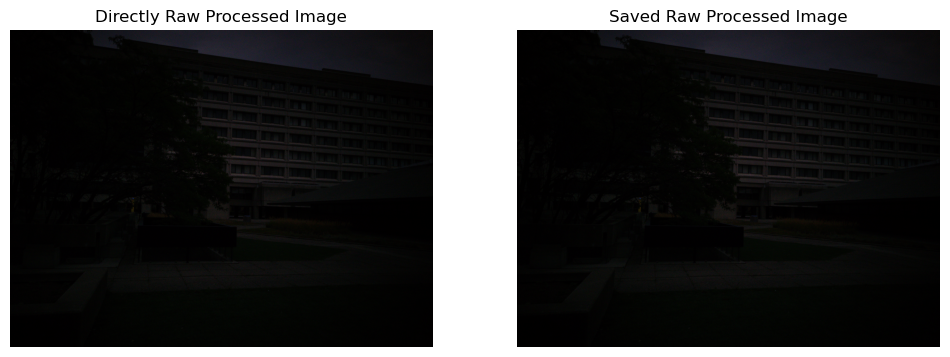

In [11]:
fig,ax = plt.subplots(1,2,figsize = [12,8])
ax[0].imshow(im_direct)
ax[0].axis('off')
ax[0].set_title('Directly Raw Processed Image')
ax[1].imshow(im_saved)
ax[1].set_title('Saved Raw Processed Image')
ax[1].axis('off')

(-0.5, 4031.5, 3023.5, -0.5)

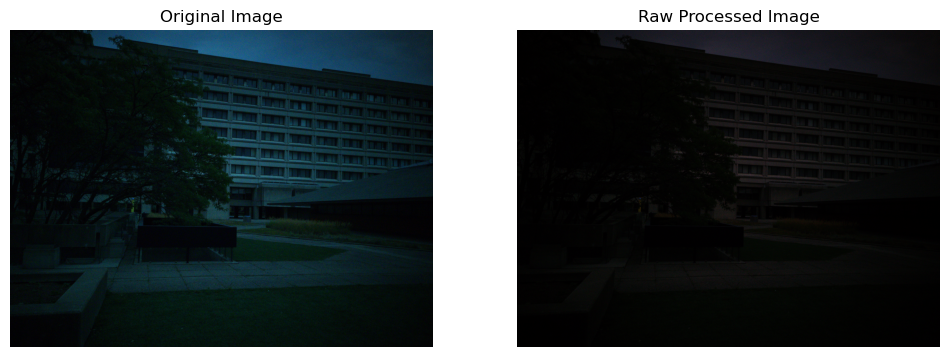

In [12]:
fig,ax = plt.subplots(1,2,figsize = [12,8])
ax[0].imshow(noisy)
ax[0].axis('off')
ax[0].set_title('Original Image')
ax[1].imshow(im_direct)
ax[1].set_title('Raw Processed Image')
ax[1].axis('off')

# SECOND PART IMAGE PROCESSING

In [13]:
from rgb_processing_synthetic.denoise import denoising_image

from rgb_processing_synthetic.contrast_enhancement import luminance_corr,new_ycbcr,contrast_fixing,ycbcr2rgb
from rgb_processing_synthetic.contrast_enhancement import saturation_fixing,glob_mean_contrast,s_curve_corr1
from rgb_processing_synthetic.contrast_enhancement import histogram_stretching,cond_contrast_corr

from rgb_processing_synthetic.sharpening import unsharp_masking

from rgb_processing_synthetic.AWB import grayness_index

In [29]:
## Denoising

# True = image being raw processed (denoising_image func. will process "iskip_raw_processing_image" variable)
# False = skip raw processing method (denoising_image func. will process "raw_processed_image" variable)
raw_process = False
skip_raw_processing_image = noisy
raw_processed_image = im_direct

image = denoising_image(skip_raw_processing_image, raw_processed_image, raw_process)

## Contrast Enhancement
# Local Contrast Enhancement
gamma = 1.8
Y,Y_ = luminance_corr(image,gamma)

old_im_ycbcr, new_im_ycbcr = new_ycbcr(image,Y_)

newY_ = new_im_ycbcr[:,:,0] # after luminance correction
im_ycbcr = contrast_fixing(old_im_ycbcr.astype(np.uint8),newY_.astype(np.uint8))
im_rgb = ycbcr2rgb(im_ycbcr)

im_rgb_s = saturation_fixing(im_rgb,old_im_ycbcr,new_im_ycbcr)

sat_fix = True
beta = 0.8

# Global Mean Contrast
if sat_fix:
    im_glob = glob_mean_contrast(im_rgb_s,beta) # Change beta value for tuning
    txt_sat = 'Sat. Fix Applied'
else:
    im_glob = glob_mean_contrast(im_rgb,beta) # Change beta value for tuning
    txt_sat = 'Sat. Fix Not Applied'

# S-Curve Correction
alpha = 0.5
lambda_value = 1.1

im_s_curve1 = s_curve_corr1(im_glob,alpha,lambda_value)

# Histogram Stretching
im_histed = histogram_stretching(im_s_curve1)

# Conditional Contrast Correction
lower_t = 5
upper_t = 100
gamma = 1.15
alpha = 0.5
lambda_value = 1.1

im_cond_corr,mean_Y,txt = cond_contrast_corr(im_histed,lower_t,upper_t,alpha,lambda_value,gamma)

## Sharpening
#Unsharp Masking
sigma = 1.5 
im_unsharped_masking = unsharp_masking(im_cond_corr,sigma)

##AWB
#Grayness Index
threshold = 4 # -> Tune the threshold value
im_awb = grayness_index(im_unsharped_masking.astype(np.uint8),threshold)


(-0.5, 4031.5, 3023.5, -0.5)

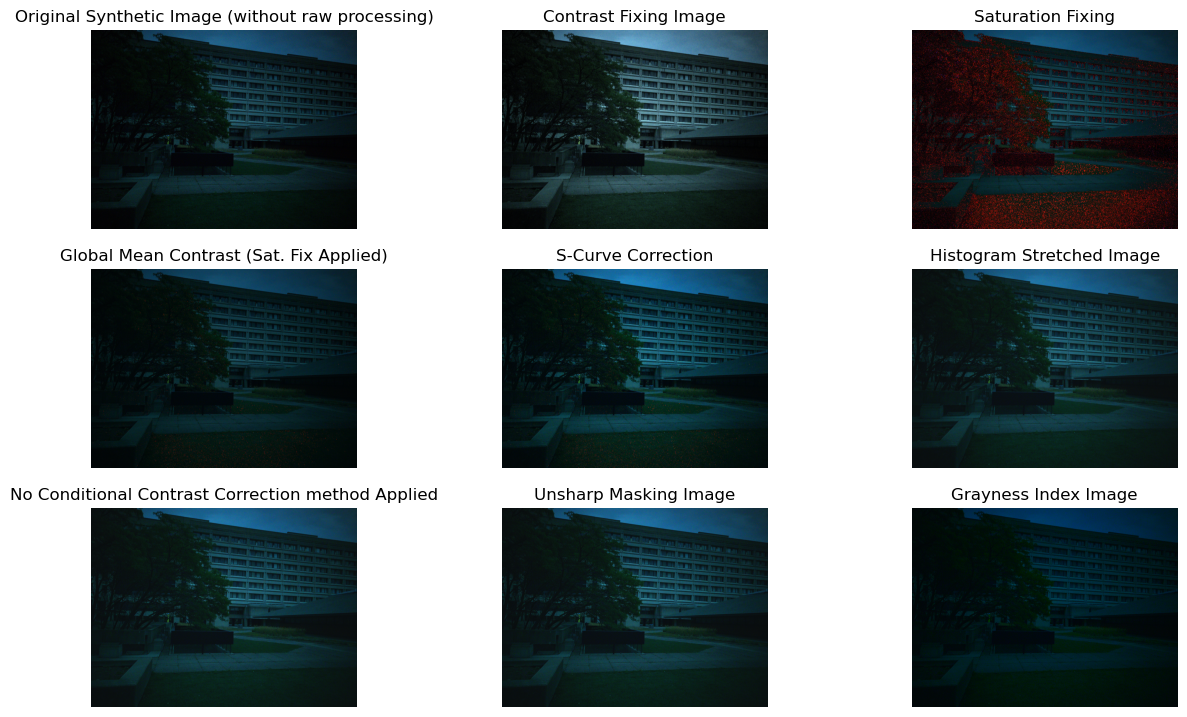

In [30]:
plt.figure(figsize=(15, 15))

n_row = 5
n_col = 3
if raw_process:
    plt.subplot(n_row,n_col,1)
    plt.imshow(raw_processed_image)
    plt.title('Original Synthetic Image (with raw processing)')
    plt.axis('off')
else:
    plt.subplot(n_row,n_col,1)
    plt.imshow(skip_raw_processing_image)
    plt.title('Original Synthetic Image (without raw processing)')
    plt.axis('off') 
    
plt.subplot(n_row,n_col,2)
plt.imshow(im_rgb)
plt.title('Contrast Fixing Image')
plt.axis('off')

plt.subplot(n_row,n_col,3)
plt.imshow(im_rgb_s.astype(np.uint8))
plt.title('Saturation Fixing')
plt.axis('off')

plt.subplot(n_row,n_col,4)
plt.imshow(im_glob.astype(np.uint8))
plt.title('Global Mean Contrast' + ' (' + txt_sat + ')')
plt.axis('off')

plt.subplot(n_row,n_col,5)
plt.imshow(im_s_curve1.astype(np.uint8))
plt.title('S-Curve Correction')
plt.axis('off')

plt.subplot(n_row,n_col,6)
plt.imshow(im_histed.astype(np.uint8))
plt.title('Histogram Stretched Image')
plt.axis('off')

plt.subplot(n_row,n_col,7)
plt.imshow(im_cond_corr.astype(np.uint8))
plt.title(txt)
plt.axis('off')

plt.subplot(n_row,n_col,8)
plt.imshow(im_unsharped_masking.astype(np.uint8))
plt.title('Unsharp Masking Image')
plt.axis('off')

plt.subplot(n_row,n_col,9)
plt.imshow(im_awb)
plt.title('Grayness Index Image')
plt.axis('off')

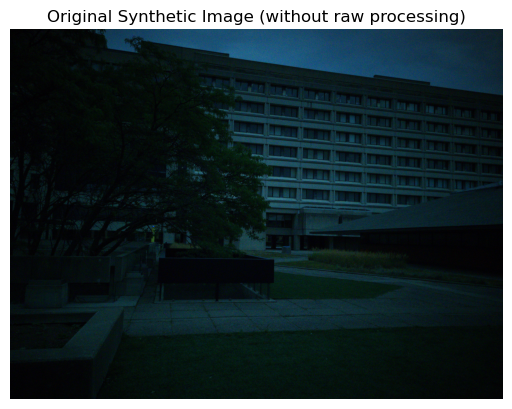

In [31]:
if raw_process:
    plt.imshow(raw_processed_image)
    plt.title('Original Synthetic Image (with raw processing)')
    plt.axis('off')
else:
    plt.imshow(skip_raw_processing_image)
    plt.title('Original Synthetic Image (without raw processing)')
    plt.axis('off') 

(-0.5, 4031.5, 3023.5, -0.5)

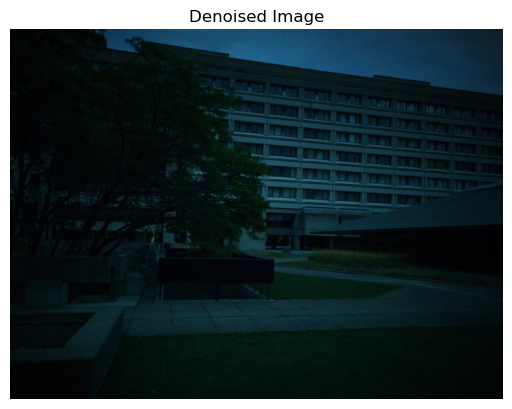

In [32]:
plt.imshow(image)
plt.title('Denoised Image')
plt.axis('off')

(-0.5, 4031.5, 3023.5, -0.5)

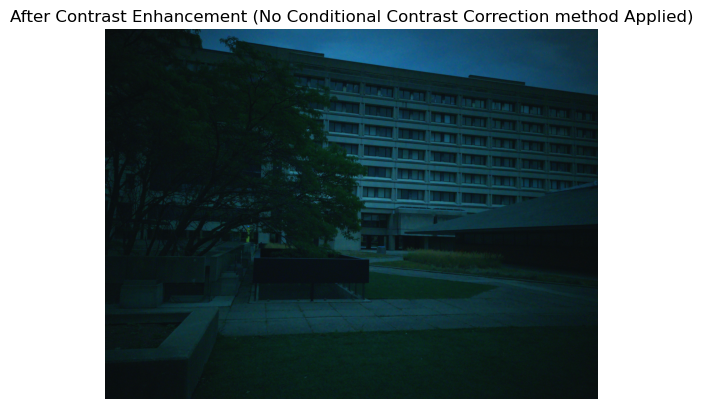

In [33]:
plt.imshow(im_cond_corr.astype(np.uint8))
plt.title('After Contrast Enhancement' + ' (' + txt + ')')
plt.axis('off')

(-0.5, 4031.5, 3023.5, -0.5)

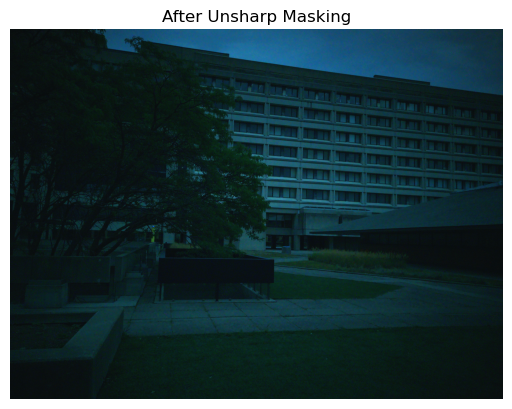

In [34]:
plt.imshow(im_unsharped_masking.astype(np.uint8))
plt.title('After Unsharp Masking')
plt.axis('off')

(-0.5, 4031.5, 3023.5, -0.5)

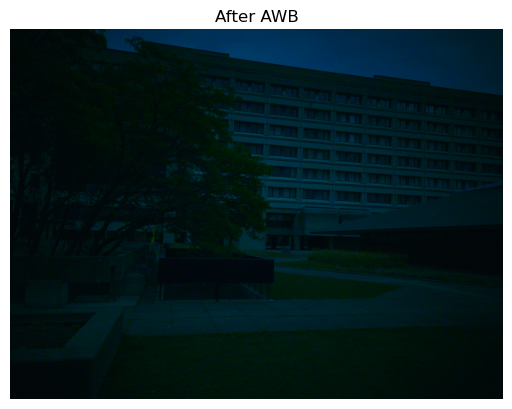

In [35]:
plt.imshow(im_awb.astype(np.uint8))
plt.title('After AWB')
plt.axis('off')